In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

sns.set_theme()

## Мультиколлинеарность и как она выглядит в линейных моделях

давайте поработаем с похожим датасетом, но с большим набором признаков из  [“Current Population Survey”](https://www.openml.org/search?type=data&sort=runs&id=534&status=active)

In [2]:
df = pd.read_csv('dataset/full_wage.csv', index_col='Unnamed: 0')
X = df.drop(['WAGE'],axis=1)
X.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,35,White,Other,Other,Married


In [3]:
X.describe(include="all")

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,44.000000,NaN,NaN,NaN,NaN


In [4]:
y = df['WAGE']
y.head()

0    5.10
1    4.95
2    6.67
3    4.00
4    7.50
Name: WAGE, dtype: float64

Давайте разделили выборку на набор данных train и тестовый набор данных test. В последующем анализе данных мы будем использовать только набор данных train. Это наш стандартный способ имитировать реальную ситуацию, когда наша модель не видит при обучении выборку test, поэтому наша модель будет непредвзятой.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

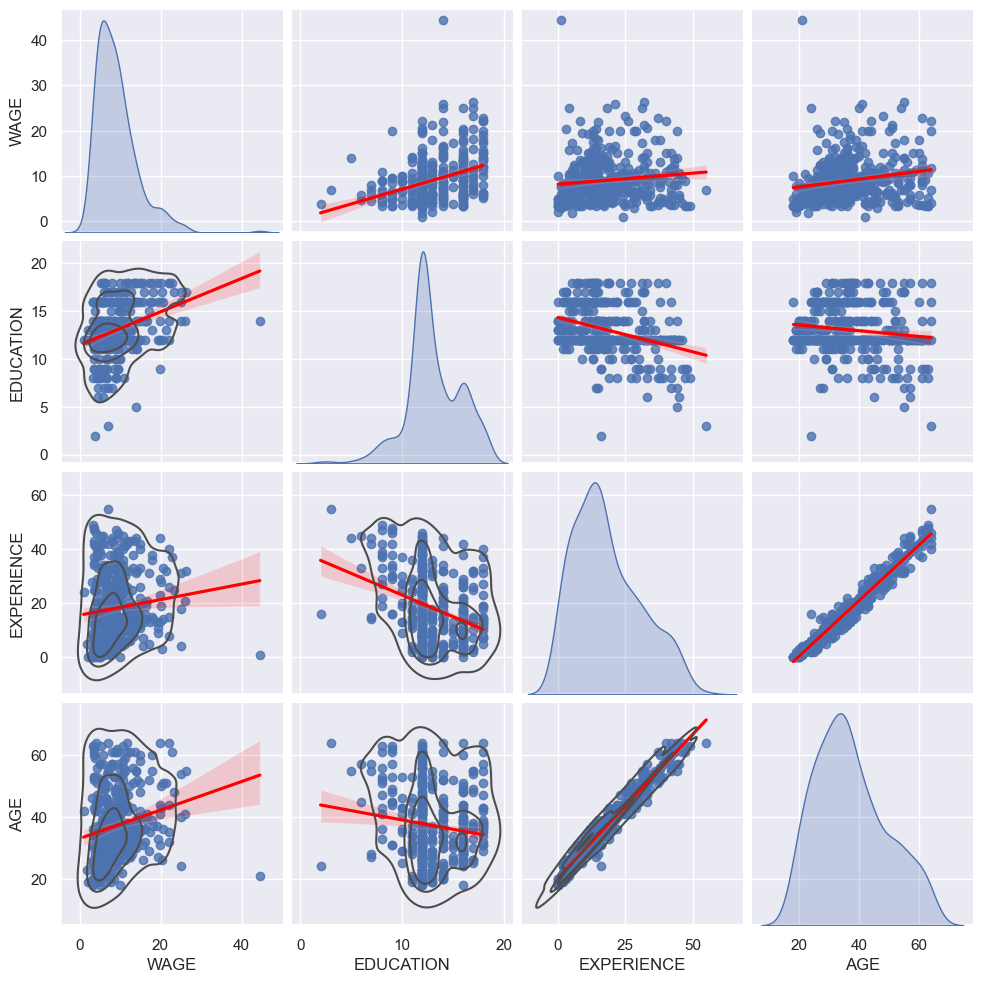

In [6]:
train_dataset = X_train.copy()
train_dataset.insert(0, "WAGE", y_train)
g=sns.pairplot(train_dataset,  diag_kind="kde", kind="reg", plot_kws={'line_kws':{'color':'red'}})
g.map_lower(sns.kdeplot, levels=4, color=".3");

Давайте посмотри мна на распределения. 
Целевая переменная WAGE имеет длинный хвост. По этой причине нам следует логарифмировать его, чтобы приблизить к нормальному распределению 
(линейные модели, такие как ridge или lasso, лучше всего подходят для нормального распределения погрешности) и при этом сохранить интерпритируемость модели.

WAGE плата растет вместе с повышением уровня EDUCATION. Обратите внимание, что представленная здесь зависимость между WAGE и EDUCATION является предельной, т.е. она описывает поведение конкретной переменной, без учета переменных.

Кроме того, EDUCATION и AGE сильно линейно коррелируют.

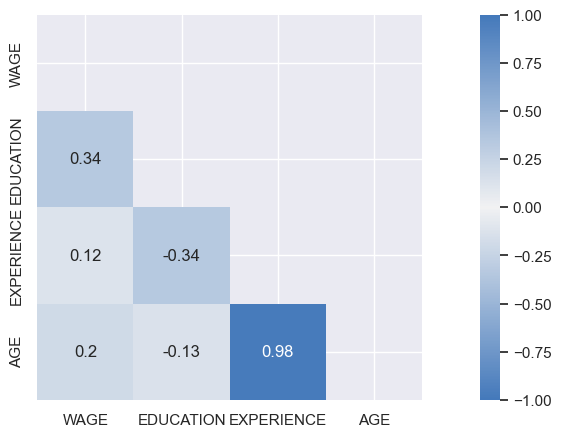

In [7]:
corr = train_dataset.corr( numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(corr,
    mask=mask,
    cmap=sns.diverging_palette(250, 250, as_cmap=True),
    annot = True,
    vmin=-1.0, vmax=1.0,
    square=True,
    ax=ax);

## Препроцессинг

Типы данных в нашем датасете:

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 204 to 102
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   EDUCATION   400 non-null    int64 
 1   SOUTH       400 non-null    object
 2   SEX         400 non-null    object
 3   EXPERIENCE  400 non-null    int64 
 4   UNION       400 non-null    object
 5   AGE         400 non-null    int64 
 6   RACE        400 non-null    object
 7   OCCUPATION  400 non-null    object
 8   SECTOR      400 non-null    object
 9   MARR        400 non-null    object
dtypes: int64(3), object(7)
memory usage: 34.4+ KB


In [9]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ["RACE", "OCCUPATION", "SECTOR", "MARR", "UNION", "SEX", "SOUTH"]
numerical_columns =   ["EDUCATION", "EXPERIENCE", "AGE"]

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary", sparse_output=False), categorical_columns),
    remainder="passthrough",
    verbose_feature_names_out=False,  # удалим имя препроцессора из имени переменной
    force_int_remainder_cols=False
).set_output(transform="pandas")

preprocessor.fit_transform(X_train).head(3)

,RACE_Hispanic,RACE_Other,RACE_White,OCCUPATION_Clerical,OCCUPATION_Management,OCCUPATION_Other,OCCUPATION_Professional,OCCUPATION_Sales,OCCUPATION_Service,SECTOR_Construction,SECTOR_Manufacturing,SECTOR_Other,MARR_Unmarried,UNION_not_member,SEX_male,SOUTH_yes,EDUCATION,EXPERIENCE,AGE
204,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,16,6,28
196,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,16,26,48
510,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,17,14,37


Возьмем линейную регрессию со слабой регуляризацией, чтобы мулитиколлинерность не так мешала, а также логарифм заработной платы - для борьбы с хвостами и поиска процентного изменения [целевой переменной](https://youtu.be/J6NwmeAB8Gg).

In [10]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
)

In [11]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline, Pipeline

model = Pipeline([
    ('ct', preprocessor),
    ('trg', TransformedTargetRegressor(
                      regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ))
])

model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR', 'UNION',
                                                   'SEX', 'SOUTH'])],
                                   verbose_feature_names_out=False)),
                ('trg',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e-10)))])

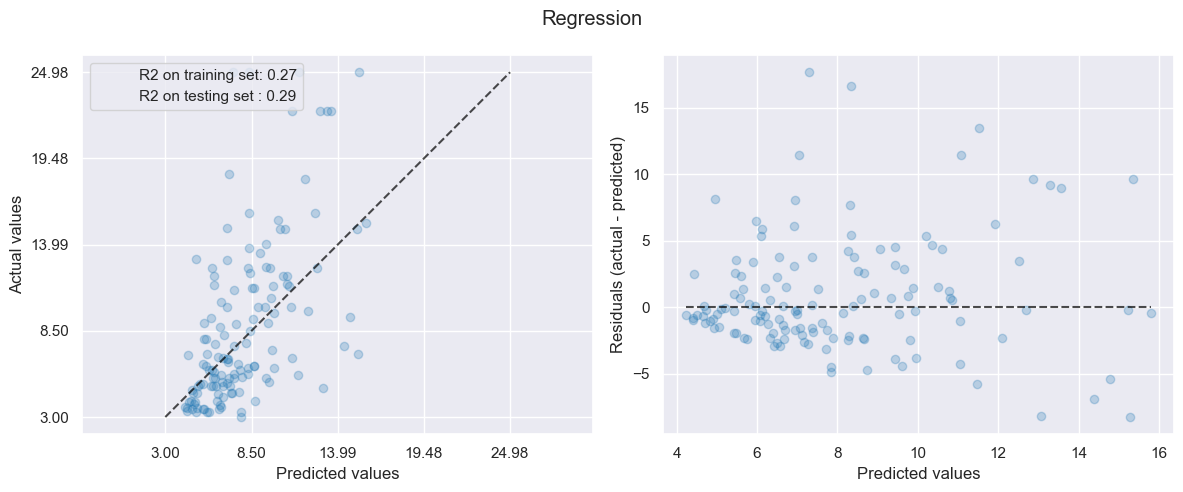

In [12]:
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error

y_pred = model.predict(X_test)
r_train = model.score(X_train,y_train)
r_test = model.score(X_test,y_test)


scores = {
    "R2 on training set": f"{r_train:.2f}",
    "R2 on testing set ": f"{r_test:.2f}",
}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
_ = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=axs[0], scatter_kwargs={"alpha": 0.25}
)
_ = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="residual_vs_predicted", ax=axs[1], scatter_kwargs={"alpha": 0.25}
)


fig.suptitle("Regression")

for name, score in scores.items():
    axs[0].plot([], [], " ", label=f"{name}: {score}")
axs[0].legend(loc="upper left")
plt.tight_layout()

Полученная модель далека от того, чтобы быть моделью, дающей точные прогнозы: это очевидно, если взять и посмотреть на графики, где правильные прогнозы лежали бы на черной пунктирной линии.

Дальше мы сосредоточимся на интерпритации коэффициентов модели. При этом мы должны понимать что, что любые наши выводы, касаются только модели, которую мы строим, а не истинного (реального) положения дел.

In [13]:
feature_names = model[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    {"Coefficients": model[-1].regressor_.coef_, 
     'Std': model[:-1].transform(X_train).std(axis=0).values},
     index=feature_names    
)

coefs

,Coefficients,Std
RACE_Hispanic,-0.013554,0.223312
RACE_Other,-0.009110,0.336725
RACE_White,0.022559,0.386740
OCCUPATION_Clerical,0.000056,0.398611
OCCUPATION_Management,0.090539,0.319421
OCCUPATION_Other,-0.025091,0.449561
OCCUPATION_Professional,0.071975,0.396697
OCCUPATION_Sales,-0.046625,0.246835
OCCUPATION_Service,-0.091042,0.355048
SECTOR_Construction,-0.000185,0.212972


Попробуем пинтерпритировать результат.

С одной стороны, коэффициент AGE выражается в "долларах в час за каждый прожитый год”, а коэффициент EDUCATION - в "долларах в час за годы обучения". Преимущество такого представления коэффициентов заключается в том, что оно делает понятными практические прогнозы модели.
- увеличение возраста с каждым годом означает уменьшение количества долларов в час,
- увеличение образования с каждым годом означает увеличение количества долларов в час. 

С другой стороны, категориальные переменные (например, UNION или SEX) представляют собой категориальную, принимающие значение 0 или 1. Их коэффициенты выражаются в долларах в час. 

Поэтому мы не сможем сравнить величину различных коэффициентов, поскольку объекты имеют разные естественные масштабы и, следовательно, диапазоны значений из-за различий в единицах измерения. 

Это будет более заметно, если мы построим график коэффициентов.

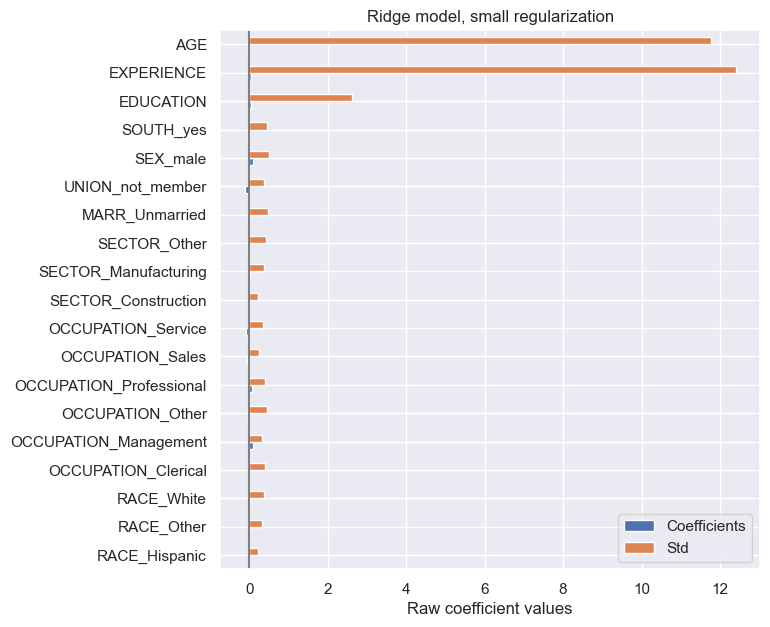

In [14]:
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

Действительно, судя по приведенному выше графику, наиболее важным фактором в определении WAGE является переменная UNION, даже если наша интуитивно кажется, что такие переменная как EXPERIENCE, должн оказывать большее влияние.

Просмотр графика коэффициентов для оценки важности признаков может ввести в заблуждение, поскольку некоторые из переменных варьируются в гораздо меньших масштабах, по сравнению с другими, например AGE, варьируются гораздо больше, на несколько десятков лет.

Это становится очевидным, если сравнить стандартные отклонения различных признаков.

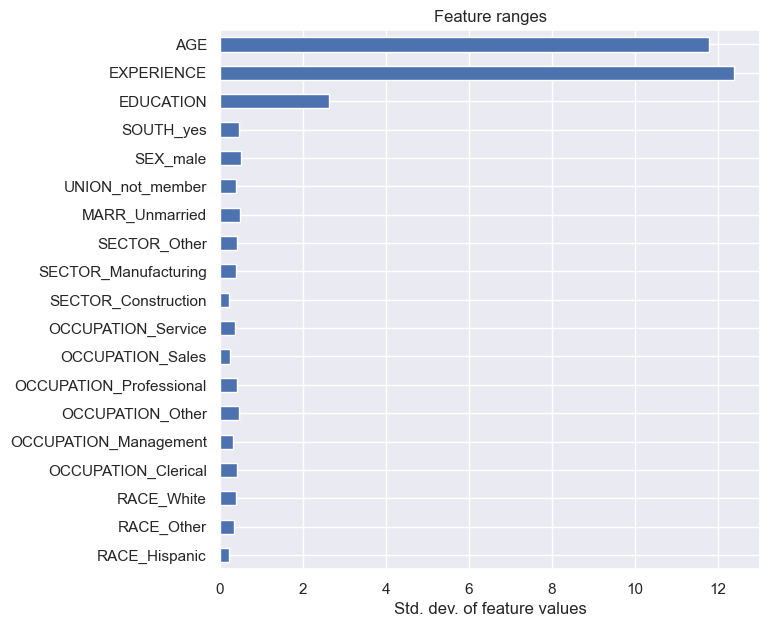

In [15]:
X_train_preprocessed = pd.DataFrame(
    model[:-1].transform(X_train), columns=feature_names
)

X_train_preprocessed.std(axis=0).plot.barh(figsize=(9, 7))
plt.title("Feature ranges")
plt.xlabel("Std. dev. of feature values")
plt.subplots_adjust(left=0.3)

Преобразование которое мы выполним принципиально совпадает с результатами `StandardScaler` (дальше мы его вставим в препроцессинг):

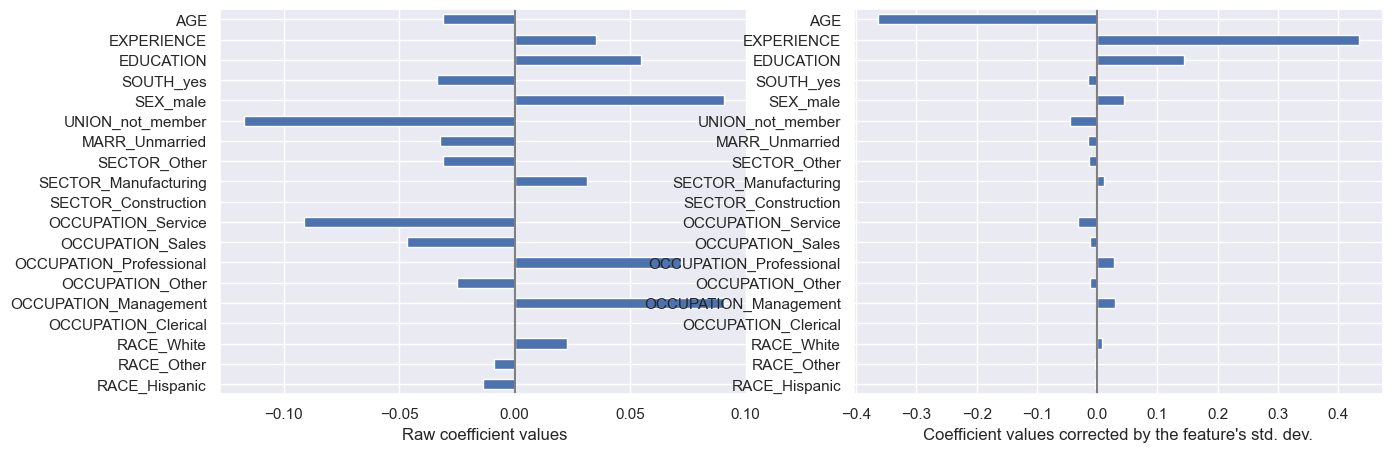

In [16]:
coefs["Coefficient importance"] = coefs['Coefficients']*coefs['Std']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
coefs['Coefficients'].plot.barh(ax=axs[0])
axs[0].axvline(x=0, color=".5")
axs[0].set_xlabel("Raw coefficient values");

coefs["Coefficient importance"].plot.barh(ax=axs[1])
axs[1].set_xlabel("Coefficient values corrected by the feature's std. dev.")
axs[1].axvline(x=0, color=".5");

Посмотрите как изменились коэффициенты после масштабирования. Вот теперь мы смело можем их сравнивать (правый график).

Правый график показывает нам зависимости между конкретной характеристикой и целью, когда все остальные характеристики остаются неизменными:
- увеличение AGE приведет к снижению заработной платы, при прочих равных; 
- увеличение EXPERIENCE приведет к увеличению заработной платы, при прочих равных;
- увеличение EDUCATION приведет к увеличению заработной платы, при прочих равных.

Кроме того, AGE, EXPERIENCE и EDUCATION являются тремя переменными, которые в наибольшей степени влияют на модель.

***При нтерпретации коэффициентов: будьте осторожны в отношении причинно-следственной связи.***

Линейные модели - отличный инструмент для измерения статистической взаимосвязи связи, но мы должны быть осторожны, делая заявления о их причинно-следственной связи, в конце концов, корреляция не всегда подразумевает причинно-следственную связь. Это особенно сложно в социальных науках, потому что переменные, которые мы наблюдаем, являются отображением сложного причинно-следственного процесса.

В нашем конкретном случае мы можем рассматривать EDUCATION человека как показатель его профессиональных способностей, реальную переменную, которая нас интересовала бы, но которую мы не можем наблюдать и реально измерить. 

Конечно, хотелось бы думать, что более длительное образование повысит профессиональную компетентность человека, но также вполне возможно, что причинно-следственная связь работает и в обратном направлении. То есть те, кто обладает более высокой профессианальной компетентностью, как правило, остаются обучаются дольше (через повышение квалификации, например).

В реальности работодателя вряд ли будет беспокоить, о каком случае идет речь (или о сочетании того и другого), но до тех пор, пока он убежден, что человек с более высоким уровнем образования лучше подходит для этой работы, он будет выплачивать более высокую заработную плату при прочих равных.

Такое наложение(смещение) эффектов начинает вызывать проблеммы, когда речь заходит о какой-либо форме "вмешательства", например, о государственного образования для получение высшего образования или рекламе, поощряющих людей к получению высшего образования. Полезность этих мер может оказаться завышенной, особенно если степень смешения велика. 

Наша модель предсказывает, что увеличение почасовой оплаты за каждый год обучения. Фактический причинно-следственный эффект может быть ниже из-за этих ненаблюдаемых эффектов.

## Проверка устойчивости полученных коэффициентов.

Давайте проверим устойчивость полученных коэффициентов с помощью перекрестной проверки - как одна из формы пребора данных связанная с повторной выборкой и переподстановкой в модель.

Если коэффициенты значительно изменяются при изменении сатистистически похожего входного набора данных, их надежность не гарантируется, и, вероятно, их следует интерпретировать с осторожностью.

In [17]:
from sklearn.model_selection import RepeatedKFold, cross_validate

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=-1,
)


coefs = pd.DataFrame(
    [
        est[-1].regressor_.coef_ * est[:-1].transform(X.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))
    ],
    columns=feature_names,
)

coefs

,RACE_Hispanic,RACE_Other,RACE_White,OCCUPATION_Clerical,OCCUPATION_Management,OCCUPATION_Other,OCCUPATION_Professional,OCCUPATION_Sales,OCCUPATION_Service,SECTOR_Construction,SECTOR_Manufacturing,SECTOR_Other,MARR_Unmarried,UNION_not_member,SEX_male,SOUTH_yes,EDUCATION,EXPERIENCE,AGE
0,-0.003552,-0.002688,0.009380,0.001302,0.028044,-0.011741,0.026240,-0.012418,-0.029956,0.000539,0.010882,-0.012848,-0.013525,-0.044140,0.042869,-0.014319,0.140299,0.428517,-0.360349
1,-0.004333,-0.003137,0.011030,0.000327,0.028034,-0.019112,0.027286,-0.014754,-0.024707,0.008946,0.001618,-0.020631,-0.009276,-0.033233,0.053506,-0.021236,0.143503,0.364278,-0.298259
2,-0.003948,-0.002527,0.009575,-0.001532,0.029366,-0.008431,0.027625,-0.015789,-0.029687,-0.002512,0.010186,-0.005134,-0.012069,-0.028958,0.052579,-0.023826,0.143995,0.337255,-0.267861
3,-0.000366,-0.005729,0.007184,0.001679,0.027509,-0.001750,0.025747,-0.020842,-0.024941,0.001054,0.006855,-0.009611,-0.013230,-0.039139,0.036905,-0.017613,0.140702,0.301130,-0.240627
4,-0.010855,0.002550,0.016321,0.001041,0.027746,-0.010509,0.030403,-0.021026,-0.025269,0.001966,0.010442,-0.015214,-0.016524,-0.032001,0.049195,-0.014790,0.038218,-0.125869,0.167488
5,-0.005633,-0.002364,0.013052,0.000766,0.022796,-0.004611,0.025684,-0.018325,-0.023138,-0.000424,0.010226,-0.010260,-0.007606,-0.042093,0.048868,-0.024444,0.135125,0.339969,-0.276339
6,-0.004406,0.000189,0.007105,0.002325,0.031335,-0.012377,0.031917,-0.021085,-0.030458,0.005478,0.000666,-0.012621,-0.018001,-0.029279,0.048332,-0.023782,0.129665,0.321024,-0.264471
7,-0.008092,-0.000017,0.014327,-0.001778,0.027419,-0.010127,0.028695,-0.013280,-0.028997,0.000695,0.008265,-0.010217,-0.017793,-0.025044,0.046237,-0.019372,0.143455,0.352588,-0.285236
8,-0.004166,-0.001237,0.008576,-0.001164,0.025303,-0.014299,0.025897,-0.012553,-0.022445,0.006042,0.004672,-0.016613,-0.014310,-0.036412,0.048520,-0.009780,0.058068,-0.070316,0.122558
9,-0.001299,-0.007322,0.010598,0.002650,0.033747,-0.010079,0.025113,-0.019756,-0.029784,-0.000855,0.014067,-0.013365,-0.009227,-0.043184,0.043770,-0.014434,0.145315,0.407537,-0.335841


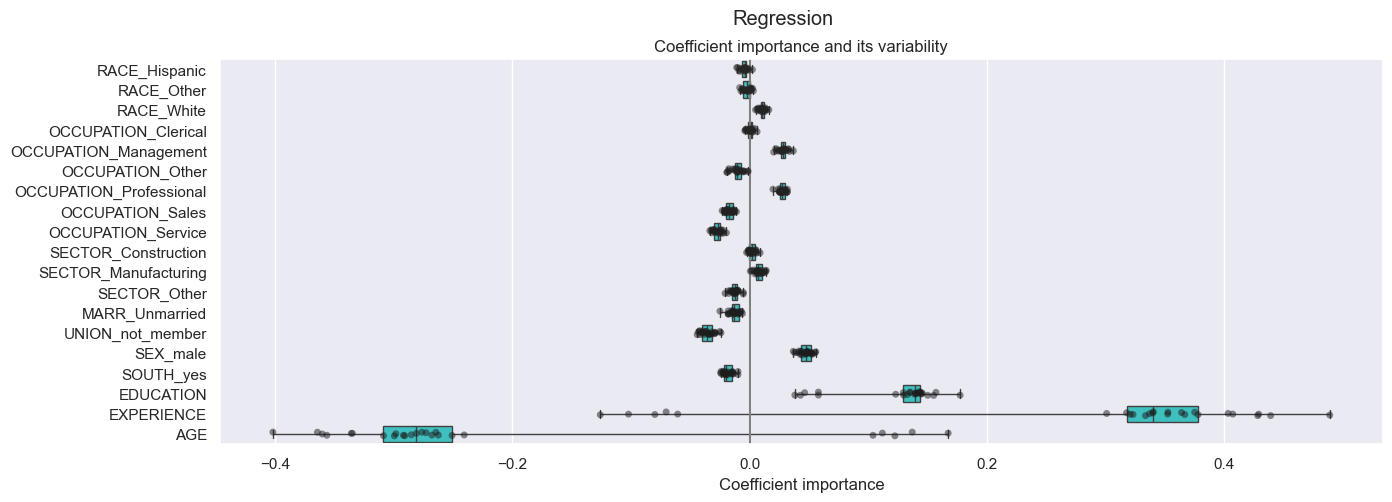

In [18]:
plt.figure(figsize=(15, 5))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.suptitle("Regression");

***Что же произошло?***

Коэффициенты AGE и EXPERIENCE не являются устойчивыми, у них значительный разброс в зависимости от фолда кросвалидации. Это может быть вызвано мультиколлинеарностью между этими двумя признаками: поскольку AGE и EXPERIENCE в данных ростут одновременно, их влияние трудно разделить.

Чтобы проверить эту интерпретацию, мы построим график коэффициентов AGE и EXPERIENCE.  

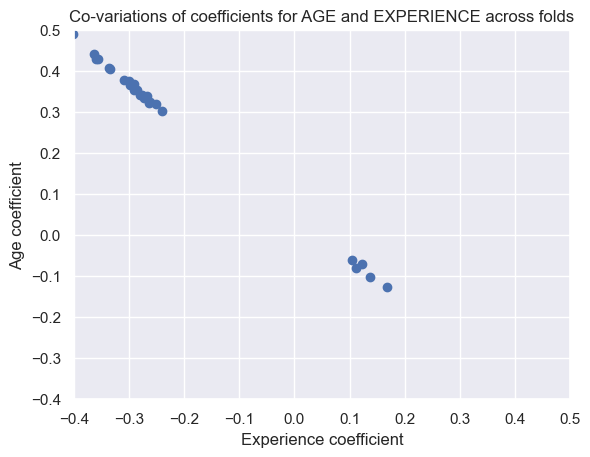

In [19]:
plt.ylabel("Age coefficient")
plt.xlabel("Experience coefficient")
plt.grid(True)
plt.xlim(-0.4, 0.5)
plt.ylim(-0.4, 0.5)
plt.scatter(coefs["AGE"], coefs["EXPERIENCE"])
_ = plt.title("Co-variations of coefficients for AGE and EXPERIENCE across folds")

Мы видим две области: когда коэффициент EXPERIENCE положительный, AGE область отрицательная, и наоборот.

Чтобы продолжить, мы удаляем одну из двух функций и проверяем, как это влияет на стабильность модели, более "интуитивно" оставить C.

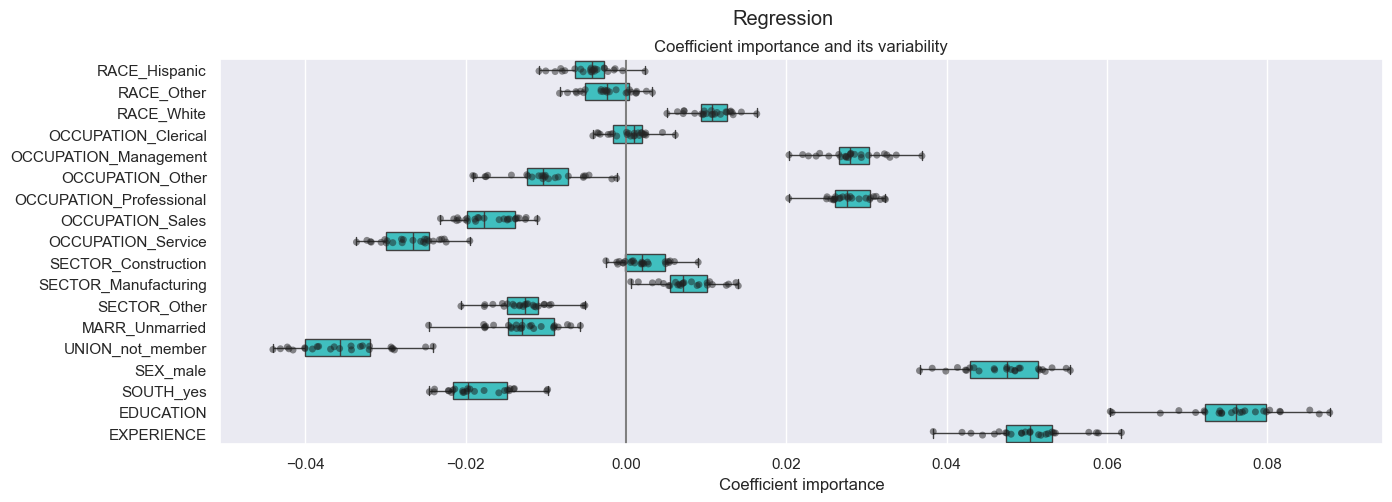

In [20]:
column_to_drop = ["AGE"]

cv_model = cross_validate(
    model,
    X.drop(columns=column_to_drop),
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=-1,
)


coefs = pd.DataFrame(
    [
        est[-1].regressor_.coef_ * est[:-1].transform(X.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))
    ],
    columns=feature_names,
).dropna(axis = 1, how = 'all')

plt.figure(figsize=(15, 5))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.suptitle("Regression");

Оценка коэффициента EXPERIENCE теперь показывает значительно меньший разброс. EXPERIENCE остается одинаково важным для всех моделей, прошедших обучение в ходе перекрестной проверки.